In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor  #GBM algorithm
from sklearn import cross_validation, metrics  #Additional scklearn functions
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

D:\Users\zeyang\Miniconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Users\zeyang\Miniconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df = pd.read_csv('train.csv')
del df['id']
dummy_df = pd.get_dummies(df)

In [3]:
features = [c for c in dummy_df.columns if c != 'loss']
target = dummy_df['loss'].values

In [4]:
def modelfit(model, train_data, features, performCV=True, cv_folds=5, printFeatureImportance=True):
    model.fit(train_data[features], train_data['loss'])
    
    predictions = model.predict(train_data[features])
    if performCV:
        #score_func = make_scorer(metrics.mean_squared_error, greater_is_better=False)
        cv_score = cross_validation.cross_val_score(model, train_data[features], 
                                                    train_data['loss'], cv=cv_folds,
                                                    n_jobs=4, scoring='neg_mean_squared_error',
                                                    )
    
    print('Mean square error {}'.format(metrics.mean_squared_error(train_data['loss'].values, predictions)))
    
    if performCV:
        print('CV Score: Mean - {} | Std - {} | Min - {} | Max - {}'.format(
            -np.mean(cv_score),
            np.std(cv_score),
            -np.max(cv_score),
            -np.min(cv_score)))
        
    if printFeatureImportance:
        feat_imp = pd.Series(model.feature_importances_, features).sort_values(ascending=False)[:10]
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

For a gradient boosting model, there are 3 kinds of parmameters:<br>
1. tree-specific
2. boosting
3. miscellaneous parameters

A general approach to train a GBM:<br>
1. Choose a relatively high learning rate. Generally the default value of 0.1 works but somewhere between 0.05 to 0.2 should work for different problems
2. Determine the optimum number of trees for this learning rate. This should range around 40-70. Remember to choose a value on which your system can work fairly fast. This is because it will be used for testing various scenarios and determining the tree parameters.
3. Tune tree-specific parameters for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
4. Lower the learning rate and increase the estimators proportionally to get more robust models

#### Tree specific parameters:
1. min_samples_split = 500 : This should be ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.
2. min_samples_leaf = 50 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
3. max_depth = 8 : Should be chosen (5-8) based on the number of observations and predictors. This has 87K rows and 49 columns so lets take 8 here.
4. max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.
5. subsample = 0.8 : This is a commonly used used start value

References:
1. http://www.ccs.neu.edu/home/vip/teach/MLcourse/4_boosting/slides/gradient_boosting.pdf
2. https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
3. http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/

Try to train a GBM by using parameters selected based on intuition.

In [113]:
params = {'n_estimators': 60, 'learning_rate': 0.1, 'min_samples_split': 1800, 
          'min_samples_leaf': 50, 'max_depth': 8, 'max_features': 'sqrt', 'subsample': 0.8, 
          'random_state': 10, 'loss': 'ls'}
model = GradientBoostingRegressor(**params)

Mean square error 3842112.6796678584
CV Score: Mean - 3952696.6976141683 | Std - 95185.57782344749 | Min - 3831775.6214171518 | Max - 4068635.2153117447


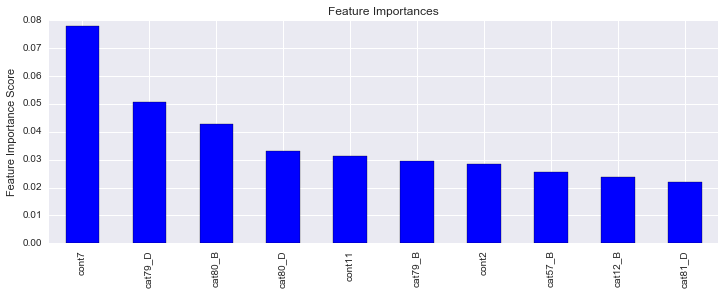

In [114]:
modelfit(model, dummy_df, features)

### Parameter Tuning

#### number of estimators

In [119]:
estimators = {'n_estimators':list(range(20,81,10))}
model_params = {'learning_rate': 0.1, 'min_samples_split': 1800, 
                'min_samples_leaf': 50, 'max_depth': 8, 'max_features': 'sqrt', 'subsample': 0.8, 
                'random_state': 10, 'loss': 'ls'}

In [122]:
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(**model_params), 
                        param_grid = estimators, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(dummy_df[features], dummy_df['loss'])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=8,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=50,
             min_samples_split=1800, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=10,
             subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [123]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -4768669.01654, std: 124141.56583, params: {'n_estimators': 20},
  mean: -4366829.62117, std: 120901.51594, params: {'n_estimators': 30},
  mean: -4144515.53353, std: 109348.15004, params: {'n_estimators': 40},
  mean: -4029902.79980, std: 103908.71091, params: {'n_estimators': 50},
  mean: -3952696.69761, std: 95185.57782, params: {'n_estimators': 60},
  mean: -3894807.27001, std: 90614.36102, params: {'n_estimators': 70},
  mean: -3856532.56529, std: 89878.71891, params: {'n_estimators': 80}],
 {'n_estimators': 80},
 -3856532.5652858512)

The optimal estimators for 0.1 learning rate is 80, which is the maximum value in the range, this indicates that the optimal estimators could be higher than 80. 

In [124]:
estimators = {'n_estimators':list(range(80,201,20))}
model_params = {'learning_rate': 0.1, 'min_samples_split': 1800, 
                'min_samples_leaf': 50, 'max_depth': 8, 'max_features': 'sqrt', 'subsample': 0.8, 
                'random_state': 10, 'loss': 'ls'}

In [125]:
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(**model_params), 
                        param_grid = estimators, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch2.fit(dummy_df[features], dummy_df['loss'])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=8,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=50,
             min_samples_split=1800, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=10,
             subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [80, 100, 120, 140, 160, 180, 200]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [126]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: -3856532.56529, std: 89878.71891, params: {'n_estimators': 80},
  mean: -3799621.98359, std: 81005.95344, params: {'n_estimators': 100},
  mean: -3766044.94894, std: 81170.11998, params: {'n_estimators': 120},
  mean: -3741065.33839, std: 79141.24886, params: {'n_estimators': 140},
  mean: -3721595.73125, std: 77111.30915, params: {'n_estimators': 160},
  mean: -3702576.74594, std: 73916.44904, params: {'n_estimators': 180},
  mean: -3689287.25372, std: 72455.61686, params: {'n_estimators': 200}],
 {'n_estimators': 200},
 -3689287.253723553)

It still hits the maximum value 200. Try estimator numbers from 200 to 1000, but increase learning rate to 0.5 to save computation time.

In [8]:
estimators = {'n_estimators':list(range(200,1001,200))}
model_params = {'learning_rate': 0.5, 'min_samples_split': 1800, 
                'min_samples_leaf': 50, 'max_depth': 8, 'max_features': 'sqrt', 'subsample': 0.8, 
                'random_state': 10, 'loss': 'ls'}

In [9]:
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(**model_params), 
                        param_grid = estimators, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch3.fit(dummy_df[features], dummy_df['loss'])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.5, loss='ls', max_depth=8,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=50,
             min_samples_split=1800, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=10,
             subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [200, 400, 600, 800, 1000]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [10]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -3824580.26733, std: 40429.87340, params: {'n_estimators': 200},
  mean: -3845968.91417, std: 25323.06381, params: {'n_estimators': 400},
  mean: -3878790.68418, std: 28222.82928, params: {'n_estimators': 600},
  mean: -3903485.39142, std: 22469.32946, params: {'n_estimators': 800},
  mean: -3931857.99926, std: 11933.30456, params: {'n_estimators': 1000}],
 {'n_estimators': 200},
 -3824580.2673277715)

From this batch of nestimators parameters, we can fix n to 200. Note 200 may still not be the optimal value because we have increased learning rate to 0.5 to reduce computation time.

In [47]:
best_estimators = 200

#### max_depth and min_samples_split

In [14]:
estimators = {'max_depth':list(range(5,16,2)), 'min_samples_split':list(range(1400,2400,200))}
model_params = {'learning_rate': 0.1, 'min_samples_leaf': 50, 
                'max_features': 'sqrt', 'subsample': 0.8, 
                'random_state': 10, 'loss': 'ls',
                'n_estimators': best_estimators}

In [15]:
gsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(**model_params), 
                        param_grid = estimators, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch4.fit(dummy_df[features], dummy_df['loss'])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=50,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=10,
             subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [1400, 1600, 1800, 2000, 2200], 'max_depth': [5, 7, 9, 11, 13, 15]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [16]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: -3792088.20105, std: 98500.33885, params: {'min_samples_split': 1400, 'max_depth': 5},
  mean: -3793616.57114, std: 94738.92951, params: {'min_samples_split': 1600, 'max_depth': 5},
  mean: -3802736.54866, std: 92812.55912, params: {'min_samples_split': 1800, 'max_depth': 5},
  mean: -3813463.76624, std: 89896.02232, params: {'min_samples_split': 2000, 'max_depth': 5},
  mean: -3810836.79696, std: 89579.44695, params: {'min_samples_split': 2200, 'max_depth': 5},
  mean: -3709949.96364, std: 86780.24629, params: {'min_samples_split': 1400, 'max_depth': 7},
  mean: -3716137.40800, std: 78662.02916, params: {'min_samples_split': 1600, 'max_depth': 7},
  mean: -3706527.18591, std: 89415.06296, params: {'min_samples_split': 1800, 'max_depth': 7},
  mean: -3718381.64372, std: 94866.16174, params: {'min_samples_split': 2000, 'max_depth': 7},
  mean: -3733493.61820, std: 88833.78905, params: {'min_samples_split': 2200, 'max_depth': 7},
  mean: -3661945.00814, std: 76236.69539, params: 

The optimal max_depth is 15, but the optimal min_saples_split of this grid search is 1400, which is the minimum value in the range.

In [17]:
best_max_depth = 15

In [19]:
estimators = {'min_samples_split':list(range(100,1400,200))}
model_params = {'learning_rate': 0.1, 'min_samples_leaf': 50, 
                'max_features': 'sqrt', 'subsample': 0.8, 
                'random_state': 10, 'loss': 'ls',
                'n_estimators': best_estimators, 'max_depth': best_max_depth}

In [20]:
gsearch5 = GridSearchCV(estimator = GradientBoostingRegressor(**model_params), 
                        param_grid = estimators, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch5.fit(dummy_df[features], dummy_df['loss'])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=15,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=50,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=10,
             subsample=0.8, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [100, 300, 500, 700, 900, 1100, 1300]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [22]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: -3591559.66493, std: 80447.05881, params: {'min_samples_split': 100},
  mean: -3599964.00613, std: 85984.77205, params: {'min_samples_split': 300},
  mean: -3595052.37844, std: 83646.26926, params: {'min_samples_split': 500},
  mean: -3600049.39910, std: 74367.36698, params: {'min_samples_split': 700},
  mean: -3606893.70257, std: 80310.45445, params: {'min_samples_split': 900},
  mean: -3610026.14683, std: 86581.18360, params: {'min_samples_split': 1100},
  mean: -3616993.00829, std: 82602.83865, params: {'min_samples_split': 1300}],
 {'min_samples_split': 100},
 -3591559.6649335995)

In [43]:
best_min_samples_split = 100

#### subsample

In [28]:
grid_parameters = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
model_params = {'learning_rate': 0.1, 'min_samples_leaf': 50, 
                'max_features': 'sqrt', 'min_samples_split': best_min_samples_split,
                'random_state': 10, 'loss': 'ls',
                'n_estimators': best_estimators, 'max_depth': best_max_depth}

In [29]:
gsearch7 = GridSearchCV(estimator = GradientBoostingRegressor(**model_params), 
                        param_grid = grid_parameters, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch7.fit(dummy_df[features], dummy_df['loss'])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=15,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=50,
             min_samples_split=40, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=10,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [30]:
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: -3616129.34031, std: 88840.25645, params: {'subsample': 0.6},
  mean: -3601675.81786, std: 88907.99045, params: {'subsample': 0.7},
  mean: -3601468.00289, std: 80435.01447, params: {'subsample': 0.75},
  mean: -3591559.66493, std: 80447.05881, params: {'subsample': 0.8},
  mean: -3589418.70110, std: 80290.06140, params: {'subsample': 0.85},
  mean: -3584452.73371, std: 91638.60324, params: {'subsample': 0.9}],
 {'subsample': 0.9},
 -3584452.733710666)

In [31]:
best_subsample = 0.9

#### min_samples_leaf

In [37]:
grid_parameters = {'min_samples_leaf': list(range(30, 71, 10))}
model_params = {'learning_rate': 0.1, 'subsample': 0.9,
                'max_features': 'sqrt', 'min_samples_split': best_min_samples_split,
                'random_state': 10, 'loss': 'ls',
                'n_estimators': best_estimators, 'max_depth': best_max_depth}

In [38]:
gsearch8 = GridSearchCV(estimator = GradientBoostingRegressor(**model_params), 
                        param_grid = grid_parameters, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch8.fit(dummy_df[features], dummy_df['loss'])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=15,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=40, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=10,
             subsample=0.9, verbose=0, warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_samples_leaf': [30, 40, 50, 60, 70]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [39]:
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

([mean: -3593434.05566, std: 80642.49819, params: {'min_samples_leaf': 30},
  mean: -3584346.54072, std: 81333.50725, params: {'min_samples_leaf': 40},
  mean: -3584452.73371, std: 91638.60324, params: {'min_samples_leaf': 50},
  mean: -3579687.16140, std: 79604.03572, params: {'min_samples_leaf': 60},
  mean: -3586420.12107, std: 94328.09744, params: {'min_samples_leaf': 70}],
 {'min_samples_leaf': 60},
 -3579687.1614041217)

In [40]:
best_min_samples_leaf = 60

We have finished all the parameter tunning, the optimal values for each parameters are:

In [45]:
best_params = {'n_estimators': best_estimators, 
               'learning_rate': 0.1, 
               'min_samples_split': best_min_samples_split, 
               'min_samples_leaf': best_min_samples_leaf, 
               'max_depth': best_max_depth, 
               'max_features': 'sqrt', 
               'subsample': best_subsample, 
               'random_state': 10, 
               'loss': 'ls'}
best_model = GradientBoostingRegressor(**best_params)

Mean square error 2866644.7489400674
CV Score: Mean - 3579687.1614041217 | Std - 79604.03572094227 | Min - 3468259.4194887825 | Max - 3687966.5542373657


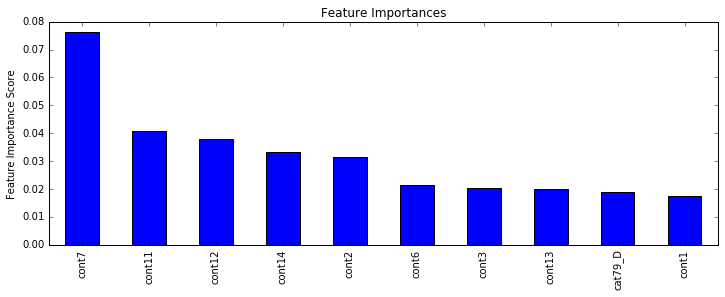

In [46]:
modelfit(best_model, dummy_df, features)

Comparing this "best model" with the model we built based on intution.<br><br>
Old model:<br>
Mean square error 3842112.6796678584<br>
CV Score: Mean - 3952696.6976141683<br><br>

"Best model":<br>
Mean square error 2866644.7489400674<br>
CV Score: Mean - 3579687.1614041217

### Test dataset

In [49]:
test_df = pd.read_csv('test.csv')

In [50]:
test_df.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,A,B,A,A,A,A,A,A,B,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,6,A,B,A,B,A,A,A,A,B,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,9,A,B,A,B,B,A,B,A,B,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,12,A,A,A,A,B,A,A,A,A,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,15,B,A,A,A,A,B,A,A,A,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


In [51]:
dummy_test_df = pd.get_dummies(test_df)

In [60]:
columns_to_drop = [c for c in dummy_test_df.columns if c not in dummy_df.columns]
columns_to_fill = [c for c in dummy_df.columns if c not in dummy_test_df.columns]

In [65]:
columns_to_drop.remove('id')
for c in columns_to_drop:
    del dummy_test_df[c]

In [68]:
columns_to_fill.remove('loss')
for c in columns_to_fill:
    dummy_test_df[c] = 0

In [75]:
test_features = dummy_test_df[features]

In [77]:
predictions = best_model.predict(test_features)

In [82]:
results = pd.Series(predictions, index=dummy_test_df['id'])
results = results.reset_index()
results.columns = ['id', 'loss']

In [85]:
results.to_csv('gbm_predictions.csv')

#### Score: 1166

##### NOTE: I made a mistake when training these models, that is, I forgot to combine training dataset and test dataset first then train the model. We need to make sure the training dataset has the same columns as the test dataset. I don't want to redo all the things again because it's really slow to find the optimal parameters. However there are couple of things we need to notice.<br>
1. The number of estimators(trees) was set to 200. But this might not be the optimal value because we increased the learning rate to 0.5 when training these models, we changed it back to 0.1 when searching other optimal parameters though.
2. min_samples_split might not be optimal because it was the minimum value in the range.
3. We didn't CV learning rate. Probably we can try some smaller learning rates, however, it really takes time..